<a href="https://colab.research.google.com/github/rahiakela/data-science-research-and-practice/blob/main/data-science-bookcamp/case-study-4--job-resume-improvement/text-similarity-analysis/03_tf_vector_normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Text similarity using tf vector normalization

In this notebook, we focus on a basic NLP problem: **measuring the similarity between two texts using word count(term-frequency) vector**. 

Binary vectorization captures the presence and absence of words in a text, but it doesn’t capture word counts. This is unfortunate since word counts can provide a differentiating
signal between texts. 

For example, suppose we’re contrasting two texts: A and B. 

Text A mentions Duck 61 times and Goose twice. Text B mentions Goose 71 times
and Duck only once, like this.

||Duck|Goose|
|--|--|--|
|A |61|2 |
|B |1 |71|

Based on the counts, we can infer that the two texts are rather different
relative to the discussion of ducks and geese. 

**This difference is not captured by binary vectorization**, which assigns a 1 to the Duck index and Goose index of both texts, like this.

||Duck|Goose|
|--|--|--|
|A |1 | 1|
|B | 1| 1|

What if we replace all binary values with actual word counts?

**A vector of word counts is commonly referred to as a term-frequency vector, or a TF vector for short.**



##Setup

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from collections import defaultdict
from collections import Counter
import time
import numpy as np
import pandas as pd

from scipy.spatial.distance import euclidean
from numpy.linalg import norm

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
def tanimoto_similarity(vector_a, vector_b):
  num_shared = vector_a @ vector_b
  num_total = vector_a @ vector_a + vector_b @ vector_b - num_shared
  return num_shared / num_total

##Preparing text 

Suppose we want to compare three simple texts:

```text
text1—She sells seashells by the seashore
text2—“Seashells! The seashells are on sale! By the seashore.”
text3—She sells 3 seashells to John, who lives by the lake.
```

Our goal is to determine whether `text1` is more similar to `text2` or to `text3`.



##Word count vector

Let’s compute
the TF vectors of A and B using a two-element vocabulary `{'duck': 0, 'goose': 1}`.

In [ ]:
# Computing TF vector similarity
A = np.array([61, 2])
B = np.array([1, 71])

similarity = tanimoto_similarity(A, B)
print(f"The similarity between texts is approximately {similarity:.3f}")

The similarity between texts is approximately 0.024


The TF vector similarity between the texts is very low. 

Let’s compare it to the binary vector
similarity of the two texts.

In [ ]:
# Assessing identical vector similarity
A = np.array([1, 1])
B = np.array([1, 1])
assert tanimoto_similarity(A, B) == 1
print(f"The similarity between texts is approximately {tanimoto_similarity(A, B):.3f}")

The similarity between texts is approximately 1.000


Replacing binary values with word counts can greatly impact our similarity output.

What will happen if we vectorize text1, text2, and text3 based on their word counts?

Let’s find out.

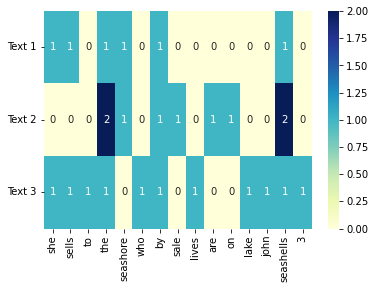

In [ ]:
# Assigning texts to variables
text1 = "She sells seashells by the seashore.".lower().replace(".", '')
text2 = "Seashells! The seashells are on sale! By the seashore.".lower().replace("!", '').replace(".", '')
text3 = "She sells 3 seashells to John, who lives by the lake.".lower().replace(",", '').replace(".", '')

# Splitting texts into words
words_lists = [text.split() for text in [text1, text2, text3]]

# Converting word lists to sets
words_sets = [set(words) for words in words_lists]

# Assigning words to numbers in a vocabulary
words_set1, words_set2, words_set3 = words_sets
total_words = words_set1 | words_set2 | words_set3

# create word-to-index vocabulary
vocabulary = {word: i for i, word in enumerate(total_words)}

# Computing TF vectors from word lists
tf_vectors = []
for i, words_list in enumerate(words_lists, 1):
  tf_vector = np.array([0] * len(vocabulary))
  for word in words_list:
    word_index = vocabulary[word]
    # Update the count of each word using its vocabulary index.
    tf_vector[word_index] += 1
  tf_vectors.append(tf_vector)

sns.heatmap(tf_vectors, cmap="YlGnBu", annot=True, xticklabels=vocabulary.keys(), yticklabels=["Text 1", "Text 2", "Text 3"])
plt.yticks(rotation=0)
plt.show()

However, the TF vector of text 2 is no longer binary since two words are mentioned
more than once. 

How will this affect the similarity between text1 and text2? 

Let’s find out.

In [ ]:
# Transforming words into binary vectors
vectors = []
for i, words_set in enumerate(words_sets, 1):
  # Generates an array of 0s
  vector = np.array([0] * len(vocabulary))
  for word in words_set:
    vector[vocabulary[word]] = 1
  vectors.append(vector)
  
# Comparing metrics of vector similarity
tf_vector1 = tf_vectors[0]
binary_vector1 = vectors[0]

for i, tf_vector in enumerate(tf_vectors[1:], 2):
  similarity = tanimoto_similarity(tf_vector1, tf_vector)
  old_similarity = tanimoto_similarity(tf_vector1, vectors[i - 1])
  print(f"The recomputed Tanimoto similarity between texts 1 and {i} is {similarity:.3f}")
  print(f"Previously, that similarity equaled {old_similarity:.3f} \n")

The recomputed Tanimoto similarity between texts 1 and 2 is 0.462
Previously, that similarity equaled 0.444 

The recomputed Tanimoto similarity between texts 1 and 3 is 0.417
Previously, that similarity equaled 0.417 



As expected, the similarity between `text1` and `text3` has stayed the same, while the
similarity between `text1` and `text2` has increased. 

Thus, **TF vectorization has made the affinity of the two texts more pronounced**.

TF vectors yield improved comparisons because they’re sensitive to count differences
between texts. This sensitivity is useful. 

However, it can also be detrimental
when comparing texts of different lengths.

There is a flaw associated with TF vector comparison.

But don't worry, there is a technique called normalization
to eliminate this flaw.

### TF vector similarity using normalization

Suppose you run a query for “Pepperoni Pizza” and the following two titles are
returned:

* **Title A**—“Pepperoni Pizza! Pepperoni Pizza! Pepperoni Pizza!”
* **Title B**—“Pepperoni”

Which of our two titles best matches the query? Most data scientists would agree that
title A is a better match than title B. 

Both title A and the query mention pepperoni pizza.
Meanwhile, title B mentions only pepperoni. There is no indication that the associated
document actually discusses pizza in any context.

Let’s check whether title A ranks higher than title B relative to the query.

In [ ]:
# Simple search engine vectorization
query_vector = np.array([1, 1])
title_a_vector = np.array([3, 3])
title_b_vector = np.array([1, 0])

In [ ]:
# Ranking titles by query similarity
titles = [
  "A: Pepperoni Pizza! Pepperoni Pizza! Pepperoni Pizza!",
  "B: Pepperoni"        
]

title_vectors = [title_a_vector, title_b_vector]
similarities = [tanimoto_similarity(query_vector, title_vector) for title_vector in title_vectors]

for index in sorted(range(len(titles)), key= lambda i: similarities[i], reverse=True):
  title = titles[index]
  similarity = similarities[index]
  print(f"{title} has a query similarity of {similarity:.4f}")

B: Pepperoni has a query similarity of 0.5000
A: Pepperoni Pizza! Pepperoni Pizza! Pepperoni Pizza! has a query similarity of 0.4286


Unfortunately, title A outranks title B. This discrepancy in rankings is caused by text
size. 

Title A has three times as many words as the query, while title B and the query differ
by just a single word.

In [ ]:
# Eliminating size differences through division
assert np.array_equal(query_vector, title_a_vector / 3)
assert tanimoto_similarity(query_vector, title_a_vector / 3) == 1

Mathematicians treat every vector v as a line stretching from
the origin to the numerical coordinates in v. 

Essentially, our three vectors are merely
2D line segments rising from the origin.

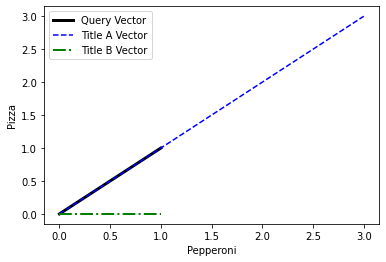

In [ ]:
# Plotting TF vectors in 2D space
plt.plot([0, query_vector[0]], [0, query_vector[1]], c="k", linewidth=3, label="Query Vector")
plt.plot([0, title_a_vector[0]], [0, title_a_vector[1]], c="b", linestyle="--", label="Title A Vector")
plt.plot([0, title_b_vector[0]], [0, title_b_vector[1]], c="g", linewidth=2, linestyle="-.", label="Title B Vector")
plt.xlabel("Pepperoni")
plt.ylabel("Pizza")
plt.legend()
plt.show()

Hence, every vector has a geometric length, which is
called the magnitude. The magnitude is also called the Euclidean norm or the L2 norm.

Measuring the magnitude allows us to account for differences in geometric lengths.

Let’s output the magnitudes of our search engine vectors.

In [ ]:
# Computing vector magnitude
vector_names = ["Query Vector", "Title A Vector", "Title B Vector"]
tf_search_vectors = [query_vector, title_a_vector, title_b_vector]
origin = np.array([0, 0])

for name , tf_vector in zip(vector_names, tf_search_vectors):
  # calculate the magnitude using Euclidean distance
  magnitude = euclidean(tf_vector, origin)
  # calculate the magnitude using Numpy's norm
  assert magnitude == norm(tf_vector)
  # calculate the magnitude using dot product
  assert magnitude == (tf_vector @ tf_vector) ** .5
  print(f"{name}'s magnitude is approximately {magnitude:.4f}")

magnitude_ratio = norm(title_a_vector) / norm(query_vector)
print(f"\nVector A is {magnitude_ratio:.0f}x as long as Query Vector")

Query Vector's magnitude is approximately 1.4142
Title A Vector's magnitude is approximately 4.2426
Title B Vector's magnitude is approximately 1.0000

Vector A is 3x as long as Query Vector


A vector with a
magnitude of 1 is referred to as a unit vector. Unit vectors have many useful properties,one benefit of unit vectors is that they are easy to compare:
since unit vectors share an equal magnitude, it doesn’t play a role in their similarity.

Fundamentally, the difference between unit vectors is determined solely by direction.

Dividing any
vector by its magnitude transforms that magnitude to 1. 

That division by the magnitude
is called normalization, since the magnitude is also referenced as the L2 norm.

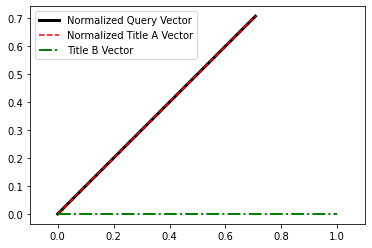

In [ ]:
# Plotting normalized vectors
unit_query_vector = query_vector / norm(query_vector)
unit_title_a_vector = title_a_vector / norm(title_a_vector)
assert np.allclose(unit_query_vector, unit_title_a_vector)
# This vector is already a unit vector.There is no need to normalize
unit_title_b_vector = title_b_vector / norm(title_b_vector)

plt.plot([0, unit_query_vector[0]], [0, unit_query_vector[1]], c="k", linewidth=3, label="Normalized Query Vector")
plt.plot([0, unit_title_a_vector[0]], [0, unit_title_a_vector[1]], c="r", linestyle="--", label="Normalized Title A Vector")
plt.plot([0, unit_title_b_vector[0]], [0, unit_title_b_vector[1]], c="g", linewidth=2, linestyle="-.", label="Title B Vector")
plt.axis("equal")
plt.legend()
plt.show()

In [ ]:
# Ranking titles by unit vector similarity
unit_title_vectors = [unit_title_a_vector, unit_title_b_vector]
similarities = [tanimoto_similarity(unit_query_vector, unit_title_vector) for unit_title_vector in unit_title_vectors]

for index in sorted(range(len(titles)), key=lambda i: similarities[i], reverse=True):
  title = titles[index]
  similarity = similarities[index]
  print(f"{title} has a normalized query similarity of {similarity:.4f}")

A: Pepperoni Pizza! Pepperoni Pizza! Pepperoni Pizza! has a normalized query similarity of 1.0000
B: Pepperoni has a normalized query similarity of 0.5469


In [ ]:
# Computing a unit vector Tanimoto similarity
def normalized_tanimoto(u1, u2):
  dot_product = u1 @ u2
  return dot_product / (2 - dot_product)

In [ ]:
for unit_title_vector in unit_title_vectors[1:]:
  similarity = normalized_tanimoto(unit_query_vector, unit_title_vector)
  assert similarity == tanimoto_similarity(unit_query_vector, unit_title_vector)

The dot product of two unit vectors is a very special value. It can easily be converted
into the angle between the vectors and also into the spatial distance between them.

Fortunately, math gives you a way out. If your vectors are normalized, their Tanimoto
similarity can be substituted with the Euclidean and cosine metrics. This is because all
three measures are very closely related to the normalized dot product.

###Relevance metrics using dot products

Geometrically, the dot product of two unit vectors equals the cosine of the angle
between them. Due to its equivalence with the cosine, the dot product of two unit
vectors is commonly referred to as the cosine similarity.



In [ ]:
# Converting between unit vector metrics
unit_vector_names = ["Normalized Title A vector", "Title B vector"]
u1 = unit_query_vector

for unit_vector_name, u2 in zip(unit_vector_names, unit_title_vectors):
  similarity = normalized_tanimoto(u1, u2)
  cosine_similarity = 2 * similarity / (1 + similarity)
  assert cosine_similarity == u1 @ u2

  angle = np.arccos(cosine_similarity)
  euclidean_distance = (2 - 2 * cosine_similarity) ** .5
  assert round(euclidean_distance, 10) == round(euclidean(u1, u2), 10)

  measurements = {
    "Tanimoto similarity": similarity,
    "cosine similarity": cosine_similarity,
    "Euclidean distance": euclidean_distance,
    "angle": np.degrees(angle)
  }

  print(f"We are comparing Normalized Query Vector and {unit_vector_names}")
  for measurement_type, value in measurements.items():
    output = f"The {measurement_type} between vectors is {value:.4f}"
    if measurement_type == "angle":
      output += " degrees\n"
    print(output)

We are comparing Normalized Query Vector and ['Normalized Title A vector', 'Title B vector']
The Tanimoto similarity between vectors is 1.0000
The cosine similarity between vectors is 1.0000
The Euclidean distance between vectors is 0.0000
The angle between vectors is 0.0000 degrees

We are comparing Normalized Query Vector and ['Normalized Title A vector', 'Title B vector']
The Tanimoto similarity between vectors is 0.5469
The cosine similarity between vectors is 0.7071
The Euclidean distance between vectors is 0.7654
The angle between vectors is 45.0000 degrees



The Tanimoto similarity between normalized vectors can be transformed into other
metrics of similarity or distance.

However, a table
of cross-text similarities can be elegantly computed using matrix multiplication. In
mathematics, matrix multiplication generalizes the dot product from one-dimensional
vectors to two-dimensional arrays.

##Similarity calculation using Matrix multiplication

Let’s generate a table of normalized Tanimoto similarities.

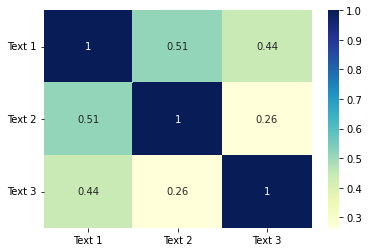

In [ ]:
# Computing a table of normalized Tanimoto similarities
num_texts = len(tf_vectors)
similarities = np.array([[0.0] * num_texts for _ in range(num_texts)])
unit_vectors = np.array([vector / norm(vector) for vector in tf_vectors])
for i, vector_a in enumerate(unit_vectors):
  for j, vector_b in enumerate(unit_vectors):
    similarities[i][j] = normalized_tanimoto(vector_a, vector_b)

labels = ["Text 1", "Text 2", "Text 3"]
sns.heatmap(similarities, cmap="YlGnBu", annot=True, xticklabels=labels, yticklabels=labels)
plt.yticks(rotation=0)
plt.show()

###Basic matrix operations

A matrix is the extension of a one-dimensional vector
to two dimensions. In other words, a matrix is just a table of numbers.

Since matrices are tables, they can be analyzed using Pandas.

In [ ]:
# Comparing Pandas and NumPy matrix attributes
matrices = [unit_vectors, pd.DataFrame(unit_vectors)]
matrix_types = ["2D NumPy array", "Pandas DataFrame"]

for matrix_type, matrix in zip(matrix_types, matrices):
  row_count, column_count = matrix.shape
  print(f"Our {matrix_type} contains {row_count} rows and {column_count} columns")
  assert (column_count, row_count) == matrix.T.shape

Our 2D NumPy array contains 3 rows and 15 columns
Our Pandas DataFrame contains 3 rows and 15 columns


**NUMPY MATRIX ARITHMETIC OPERATIONS**

Doubling the values of a matrix is very easy to do in NumPy.

In [ ]:
# NumPy array addition and subtraction
double_similarities = 2 * similarities
np.array_equal(double_similarities, similarities + similarities)
zero_matrix = similarities - similarities
negative_1_matrix = similarities - similarities - 1

for i in range(similarities.shape[0]):
  for j in range(similarities.shape[1]):
    assert double_similarities[i][j] == 2 * similarities[i][j]
    assert zero_matrix[i][j] == 0
    assert negative_1_matrix[i][j] == -1

In [ ]:
# NumPy array multiplication and division
squared_similarities = similarities * similarities
assert np.array_equal(squared_similarities, similarities ** 2)

ones_matrix = similarities / similarities

for i in range(similarities.shape[0]):
  for j in range(similarities.shape[1]):
    assert squared_similarities[i][j] == similarities[i][j] ** 2
    assert ones_matrix[i][j] == 1

In [ ]:
# Converting between matrix similarity-types
cosine_similarities = 2 * similarities / (1 + similarities)

for i in range(similarities.shape[0]):
  for j in range(similarities.shape[1]):
    # Confirms that the cosine similarity equals the actual vector dot product
    cosine_sim = unit_vectors[i] @ unit_vectors[j]
    assert round(cosine_similarities[i][j], 15) == round(cosine_sim, 15)

**NUMPY MATRIX ROW AND COLUMN OPERATIONS**

Given any 2D matrix array, we can access the row at index i by running `matrix[i]`. 

Likewise,
we can access the column at index j by running `matrix[:,j]`.

In [ ]:
# Accessing NumPy matrix rows and columns
for name, matrix in [("Similarities", similarities), ("Unit Vectors", unit_vectors)]:
  print(f"Accessing rows and columns in the {name} Matrix.")
  row, column = matrix[0], matrix[:, 0]
  print(f"Row at index 0 is:\n{row}")
  print(f"\nColumn at index 0 is:\n{column}\n")

Accessing rows and columns in the Similarities Matrix.
Row at index 0 is:
[1.         0.51442439 0.44452044]

Column at index 0 is:
[1.         0.51442439 0.44452044]

Accessing rows and columns in the Unit Vectors Matrix.
Row at index 0 is:
[0.         0.         0.40824829 0.         0.40824829 0.
 0.         0.         0.40824829 0.         0.         0.40824829
 0.40824829 0.         0.40824829]

Column at index 0 is:
[0.        0.2773501 0.       ]



In [ ]:
# Computing the dot product between a row and column
row = similarities[0]
column = unit_vectors[:, 0]
dot_product = row @ column
print(f"The dot product between the row and column is: {dot_product:.4f}")

The dot product between the row and column is: 0.1427


In [ ]:
# Computing dot products between all rows and columns
num_rows = similarities.shape[0]
num_columns = unit_vectors.shape[1]

for i in range(num_rows):
  for j in range(num_columns):
    row = similarities[i]
    column = unit_vectors[:, j]
    dot_product = row @ column
    print(f"The dot product between row {i} column {j} is: {dot_product:.4f}")

The dot product between row 0 column 0 is: 0.1427
The dot product between row 0 column 1 is: 0.1340
The dot product between row 0 column 2 is: 0.5509
The dot product between row 0 column 3 is: 0.1340
The dot product between row 0 column 4 is: 0.6850
The dot product between row 0 column 5 is: 0.1427
The dot product between row 0 column 6 is: 0.1340
The dot product between row 0 column 7 is: 0.1340
The dot product between row 0 column 8 is: 0.8276
The dot product between row 0 column 9 is: 0.1340
The dot product between row 0 column 10 is: 0.1340
The dot product between row 0 column 11 is: 0.8276
The dot product between row 0 column 12 is: 0.5423
The dot product between row 0 column 13 is: 0.1427
The dot product between row 0 column 14 is: 0.5423
The dot product between row 1 column 0 is: 0.2774
The dot product between row 1 column 1 is: 0.0797
The dot product between row 1 column 2 is: 0.4874
The dot product between row 1 column 3 is: 0.0797
The dot product between row 1 column 4 is: 0.

In [ ]:
# Storing all-by-all dot products in a matrix
dot_products = np.zeros((num_rows, num_columns))

for i in range(num_rows):
  for j in range(num_columns):
    dot_products[i][j] = similarities[i] @ unit_vectors[:, j]

print(dot_products)

[[0.14267565 0.13402795 0.55092394 0.13402795 0.6849519  0.14267565
  0.13402795 0.13402795 0.82762755 0.13402795 0.13402795 0.82762755
  0.54227624 0.14267565 0.54227624]
 [0.2773501  0.07969524 0.48736297 0.07969524 0.56705821 0.2773501
  0.07969524 0.07969524 0.84440831 0.07969524 0.07969524 0.84440831
  0.28970812 0.2773501  0.28970812]
 [0.07330896 0.30151134 0.25478367 0.30151134 0.55629501 0.07330896
  0.30151134 0.30151134 0.62960397 0.30151134 0.30151134 0.62960397
  0.48298605 0.07330896 0.48298605]]


The operation we’ve just executed is called a matrix product. It’s a generalization of the
vector dot product to two dimensions.

**NUMPY MATRIX PRODUCTS**

Conveniently, NumPy’s product operator `@`
can be applied to 2D matrices as well as 1D arrays.


In [ ]:
# Computing a matrix product using NumPy
matrix_product = similarities @ unit_vectors
assert np.allclose(matrix_product, dot_products)

In [ ]:
# Computing an erroneous matrix product
try:
  matrix_product = unit_vectors @ similarities
except:
  print("We can't compute the matrix product")

We can't compute the matrix product


In mathematics, the words product and multiplication are often interchangeable. 

Thus,computing the matrix product is commonly called matrix multiplication.

In [ ]:
# Running matrix multiplication using matmul
matrix_product = np.matmul(similarities, unit_vectors)
assert np.array_equal(matrix_product, similarities @ unit_vectors)

Let’s compare the matrix product speed between NumPy and regular Python.

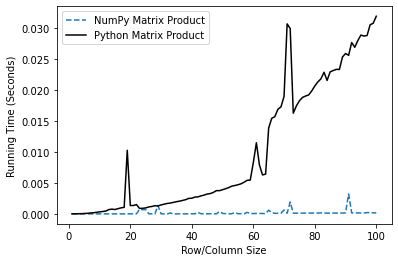

In [ ]:
# Comparing matrix product running times
numpy_run_times = []
python_run_times = []

matrix_sizes = range(1, 101)
for size in matrix_sizes:
  matrix = np.ones((size, size))

  start_time = time.time()
  matrix @ matrix
  numpy_run_times.append(time.time() - start_time)

  start_time = time.time()
  for i in range(size):
    for j in range(size):
      matrix[i] @ matrix[:, j]
  python_run_times.append(time.time() - start_time)

plt.plot(matrix_sizes, numpy_run_times, label="NumPy Matrix Product", linestyle="--")
plt.plot(matrix_sizes, python_run_times, label="Python Matrix Product", color="k")
plt.xlabel("Row/Column Size")
plt.ylabel("Running Time (Seconds)")
plt.legend()
plt.show()

###Computing all-by-all matrix similarities

What will happen if we multiply `unit_vectors` by `unit_vectors.T`?

Taking the dot product of `unit_vectors[i]` and `unit_vectors.
T[:,i]` will return the cosine similarity between a unit vector and itself.

That similarity, of course, will equal 1.

In [ ]:
# Obtaining cosines from a matrix product
cosine_matrix = unit_vectors @ unit_vectors.T
assert np.allclose(cosine_matrix, cosine_similarities)

That cosine can be transformed into a Tanimoto value, which generally reflects word overlap and divergence between texts.

In [ ]:
# Converting cosines to a Tanimoto matrix
tanimoto_matrix = cosine_matrix / (2 - cosine_matrix)
assert np.allclose(tanimoto_matrix, similarities)

We can also compute
these similarities by inputting `unit_vectors` and `unit_vectors.T` directly into our
normalized_tanimoto function.

In [ ]:
# Inputting matrices into normalized_tanimoto
output = normalized_tanimoto(unit_vectors, unit_vectors.T)
assert np.array_equal(output, tanimoto_matrix)

##Computational limits of matrix multiplication

Let’s assume that 30 novels require a shared vocabulary containing 50,000 words.

Furthermore, let’s assume we take an all-by-all similarity across the 30 books. 

How much time is required to compute these similarities? 

Let’s find out!

In [ ]:
# Timing an all-by-all comparison of 30 novels
vocabulary_size = 50000
normalized_vector = [1 / vocabulary_size] * vocabulary_size
book_count = 30

def measure_run_time(book_count):
  book_matrix = np.array([normalized_vector] * book_count)

  start_time = time.time()
  normalized_tanimoto(book_matrix, book_matrix.T)
  return time.time() - start_time

In [ ]:
run_time = measure_run_time(book_count)
print(f"It took {run_time:.4f} seconds to compute the similarities across a {book_count}-book by {vocabulary_size}-word matrix")

It took 0.0075 seconds to compute the similarities across a 30-book by 50000-word matrix


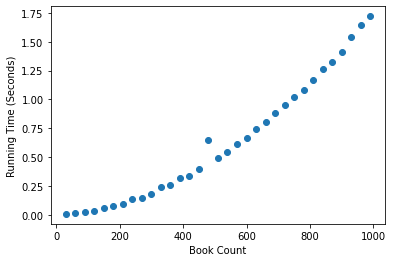

In [ ]:
# Plotting book counts vs. running times
book_counts = range(30, 1000, 30)
run_times = [measure_run_time(book_count) for book_count in book_counts]

plt.scatter(book_counts, run_times)
plt.xlabel("Book Count")
plt.ylabel("Running Time (Seconds)")
plt.show()

Our plotted curve takes on a parabolic shape
defined by `y = n * (x ** 2)`. When `x` is approximately 1,000, `y` equals approximately 0.27. Thus, we can model our running times using the equation `y = (0.27 / (1000 ** 2)) * (x ** 2)`.



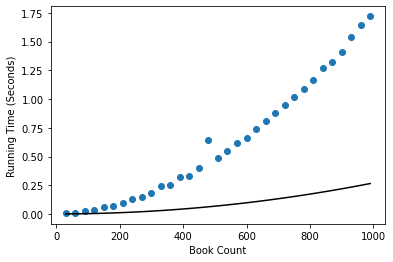

In [ ]:
def y(x):
  return (0.27 / (1000 ** 2)) * (x ** 2)

plt.scatter(book_counts, run_times)
plt.plot(book_counts, y(np.array(book_counts)), c="k")
plt.xlabel("Book Count")
plt.ylabel("Running Time (Seconds)")
plt.show()

Let’s see how long it will take to
measure the similarity across 300,000 books.

In [ ]:
# Predicting the running time for 300,000 books
book_count = 300000
run_time = y(book_count) / 3600
print(f"It took {run_time} hours to compute all-by-all similarities from a {book_count}-book by {vocabulary_size}-word matrix")

It took 6.75 hours to compute all-by-all similarities from a 300000-book by 50000-word matrix


Our matrix is too large, partially because of column size. Each row contains 50,000
columns corresponding to 50,000 words. However, in a real-world setting, not all
words are distributed equally. While some words are common across novels, other
words may appear only once.

It’s possible to systematically reduce the dimensions of each matrix row from
50,000 to a more reasonable value.

**Reducing the dimensions of text matrices greatly lowers the running times of common NLP computations**.